# 1. 250-dimensional Multivariate Normal (MVN)

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from bml.samplers import nuts, hmc
from bml.distributions.mvn import MultivariateNormal
from bml.distributions.counter import GradCounter
from bml import metrics

In [ ]:
d = 250              # dimension
theta0 = np.zeros(d) # Zero-mean starting point
M = 2000             # Total iterations
M_adapt = 1000       # Warmup/adaptation iterations
delta = 0.65         # Target acceptance rate

In [ ]:
results = {}
mvn = MultivariateNormal(d)

for sampler_name, SamplerClass in [("Dual Averaging NUTS", nuts.DualAveragingNUTS), ("Efficient NUTS", nuts.EfficientNUTS), ("Dual Averaging HMC", hmc.DualAveragingHMC)]:
    print(f"Starting {sampler_name} sampling for {d}-dimensional MVN...")
    if sampler_name == "Efficient NUTS":
        sampler = SamplerClass(epsilon=0.01, L=mvn.log_p, grad=mvn.grad_log_p)
        samples = sampler.sample(theta0, M=M)

    elif sampler_name == "Dual Averaging HMC":
        sampler = SamplerClass(L=mvn.log_p, grad=mvn.grad_log_p)
        samples, stats = sampler.sample(theta0, delta=delta, lam=0.5, M=M, M_adapt=M_adapt)
        
    else: # HMC
        sampler = SamplerClass(L=mvn.log_p, grad=mvn.grad_log_p)
        samples, stats = sampler.sample(theta0, delta=delta, M=M, M_adapt=M_adapt)

    print(f"Finished sampling with {sampler_name}. Output shape: {samples.shape}")
    
    valid_samples = samples[M_adapt:]
    min_ess = metrics.evaluate_mvn_efficiency(valid_samples, A)
    results[sampler_name] = min_ess
    print(f"Worst-case ESS across all dimensions for {sampler_name}: {min_ess:.4f}\n")

Starting Dual Averaging NUTS sampling for 250-dimensional MVN...
Finished sampling with Dual Averaging NUTS. Output shape: (2001, 250)
Worst-case ESS across all dimensions for Dual Averaging NUTS: 47.2827

Starting Efficient NUTS sampling for 250-dimensional MVN...
Finished sampling with Efficient NUTS. Output shape: (2001, 250)
Worst-case ESS across all dimensions for Efficient NUTS: 41.5563

Starting Dual Averaging HMC sampling for 250-dimensional MVN...
Finished sampling with Dual Averaging HMC. Output shape: (2001, 250)
Worst-case ESS across all dimensions for Dual Averaging HMC: 1.9015



In [ ]:
deltas = np.linspace(0.25, 0.95, 15)
results_delta = []

for delta in deltas:
    print(f"Sampling for Delta={delta:.2f}...")

    model = GradCounter(mvn)
    sampler = nuts.DualAveragingNUTS(L=model.log_p, grad=model.grad)

    theta0 = np.zeros(d)

    samples, stats = sampler.sample(theta0, delta=delta, M=M, M_adapt=M_adapt)
    valid_samples = samples[M_adapt:]
    min_ess = metrics.evaluate_mvn_efficiency(valid_samples, A)
    total_gradients = model.count
    ess_per_gradient = min_ess / total_gradients
    results_delta.append((delta, min_ess, total_gradients, ess_per_gradient))
    print(f"Delta: {delta:.2f}, Worst-case ESS: {min_ess:.4f}, Total Gradients: {total_gradients}, ESS/Gradient: {ess_per_gradient:.6f}\n")

results_df = pd.DataFrame(results_delta, columns=["Delta", "Worst-case ESS", "Total Gradients", "ESS per Gradient"])
results_df.to_csv("../results/MVN/DANUTS_delta.csv", index=False)

Sampling for Delta=0.25...
Delta: 0.25, Worst-case ESS: 20.3159, Total Gradients: 1711528, ESS/Gradient: 0.000012

Sampling for Delta=0.30...
Delta: 0.30, Worst-case ESS: 17.8312, Total Gradients: 1719048, ESS/Gradient: 0.000010

Sampling for Delta=0.35...
Delta: 0.35, Worst-case ESS: 34.1883, Total Gradients: 1809524, ESS/Gradient: 0.000019

Sampling for Delta=0.40...
Delta: 0.40, Worst-case ESS: 34.4721, Total Gradients: 1872404, ESS/Gradient: 0.000018

Sampling for Delta=0.45...
Delta: 0.45, Worst-case ESS: 46.8990, Total Gradients: 2036742, ESS/Gradient: 0.000023

Sampling for Delta=0.50...
Delta: 0.50, Worst-case ESS: 40.9844, Total Gradients: 2184712, ESS/Gradient: 0.000019

Sampling for Delta=0.55...
Delta: 0.55, Worst-case ESS: 39.0816, Total Gradients: 2434028, ESS/Gradient: 0.000016

Sampling for Delta=0.60...
Delta: 0.60, Worst-case ESS: 40.5567, Total Gradients: 2447790, ESS/Gradient: 0.000017

Sampling for Delta=0.65...
Delta: 0.65, Worst-case ESS: 40.3084, Total Gradients

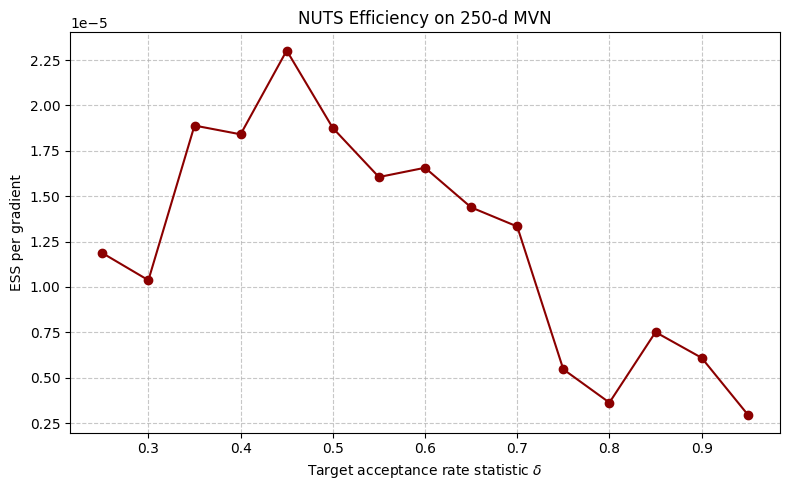

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(results_df["Delta"], results_df["ESS per Gradient"], marker='o', linestyle='-', color='darkred')
plt.xlabel('Target acceptance rate statistic $\\delta$')
plt.ylabel('ESS per gradient')
plt.title(f'NUTS Efficiency on {d}-d MVN')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"../results/MVN/{d}d_efficiency_plot.png")